In [1]:
import emat

# PRIM

Patient rule induction method (PRIM) is a scenario 
discovery algorithm that operates on an existing set of data 
with model inputs and outputs (i.e., you have already
designed and run a set of experiments using either a
core model or a meta-model.)  Generally, a decently 
size set of experiments (hundreds or thousands) 
is used to describe the solution space, although 
no minimum number of experiments is formally required.

PRIM is used for locating areas of an outcome space that 
are of particular interest, which it does by reducing 
the data size incrementally by small amounts in an 
iterative process as follows:
    
- Candidate boxes are generated.  These boxes represent 
  incrementally smaller sets of the data. Each box removes 
  a portion of the data based on the levels of a single 
  input variable.
  * For categorical input variables, there is one 
    box generated for each category with each box 
    removing one category from the data set.
  * For integer and continuous variables, two boxes 
    are generated – one box that removes a 
    portion of data representing the smallest set of 
    values for that input variable and another 
    box that removes a portion of data representing 
    the largest set of values for that input.  
    The step size for these variables is controlled 
    by the analyst.
- For each candidate box, the relative improvement 
  in the number of outcomes of interest inside 
  the box is calculated and the candidate box with 
  the highest improvement is selected.
- The data in the selected candidate box replaces 
  the starting data and the process is repeated.

The process ends based on a stopping criteria.  
For more details on the algorithm, 
see [Friedman and Fisher (1999)](http://statweb.stanford.edu/~jhf/ftp/prim.pdf) 
or [Kwakkel and Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092).

The PRIM algorithm is particularly useful for scenario 
discovery, which broadly is the process of 
identifying particular scenarios of interest in a 
large and deeply uncertain dataset.   
In the context of exploratory modeling, scenario 
discovery is often used to obtain a better understanding 
of areas of the uncertainty space where a policy or 
collection of policies performs poorly because it is 
often used in tandem with robust search methods for 
identifying policies that perform well 
([Kwakkel and Jaxa-Rozen (2016)](https://www.sciencedirect.com/science/article/pii/S1364815215301092)).

## The Mechanics of using PRIM

In order to use PRIM for scenario discovery, the analyst must
first conduct a set of experiments.  This includes having both
the inputs and outputs of the experiments (i.e., you've already
run the model or meta-model).

In [2]:
import emat.examples
scope, db, model = emat.examples.road_test()
designed = model.design_experiments(n_samples=5000, sampler='mc', random_seed=42)
results = model.run_experiments(design_name='mc')

In order to use PRIM for scenario discovery, the analyst must
also identify what constitutes a case that is "of interest".
This is essentially generating a True/False label for every 
case, using some combination of values of the output performance 
measures as well as (possibly) the values of the inputs.
Some examples of possible definitions of "of interest" might
include:

- Cases where total predicted VMT (a performance measure) is below some threshold.
- Cases where transit farebox revenue (a performance measure) is above some threshold.
- Cases where transit farebox revenue (a performance measure) is above above 50% of
  budgeted transit operating cost (a policy lever).
- Cases where the average speed of tolled lanes (a performance measure) is less 
  than free-flow speed but greater than 85% of free-flow speed (i.e., bounded both
  from above and from below).

The salient features of a definitions for "of interest" is that
it can be calculated for each case independently if given the set 
of inputs and outputs, and that the result is a True or False value.

For this example, we will define "of interest" as cases from the 
Road Test example that have positive net benefits.

In [3]:
of_interest = results['net_benefits']>0

Having defined the cases of interest, to use PRIM we pass the
explanatory data (i.e., the inputs) and the 'of_interest' variable
to the `Prim` object, and then invoke the `find_box` method.

In [4]:
from emat.analysis.prim import Prim

In [5]:
discovery = Prim(
    model.read_experiment_parameters(design_name='mc'), 
    of_interest, 
    threshold=0.2,
)

In [6]:
box1 = discovery.find_box()

The `find_box` command actually provides a number of different possible boxes
along a (heuristically) optimal trajectory, trading off coverage against
density.  We can plot a static figure showing the tradeoff curve using the 
`show_tradeoff` command:

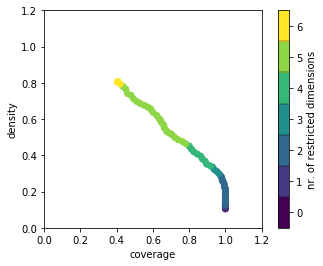

In [7]:
ax = box1.show_tradeoff()

This figure shows the trade-off between coverage and density.

- **Coverage** is percentage of the cases of interest that are in the box
  (i.e., number of cases of interest in the box divided by total number of 
  cases of interest).
  The starting point of the PRIM algorithm is the unrestricted full set of cases, 
  which includes all outcomes of interest, and therefore, the coverage starts at 
  1.0 and drops as the algorithm progresses.  
- **Density** is the share of cases in the box that are case of interest
  (i.e., number of cases of interest in the box divided by the total 
  number of cases in the box). 
  As the box is reduced, the density will increase (as that is the objective 
  of the PRIM algorithm).  

For the statistically minded, this tradeoff can also be interpreted as
the tradeoff between Type I (false positive) and Type II (false negative)
error.  High coverage minimizes the false negatives, while high density
minimizes false positives.

By default, the PRIM algorithm sets the "selected" box position as the 
particular box at the end of the peeling trajectory (highest density, at 
the top of the top of the tradeoff curve), which has the highest 
density, but the smallest coverage.

In [8]:
box1

<PrimBox peel 66 of 66>
   coverage: 0.40805
   density:  0.80682
   mean: 0.80682
   mass: 0.05280
   restricted dims: 6
                                 min        max
     expand_capacity      0.00481239    52.3027
     input_flow                  127        150
     value_of_time         0.0449284  0.0799966
     beta                    3.66673    5.49961
     amortization_period          18         50
     alpha                  0.108098   0.199972

In a Jupyter notebook, the analyst can interactively view and select other possible
boxes using the `tradeoff_selector` method.  This method opens a dynamic viewer
which shows the same basic figure as the static one above, but when hovering over
each possible tradeoff point, a pop-up box appears with more details about
that point, including which dimensions are restricted, and what the restrictions
are.  A selection of the preferred tradeoff can be made by clicking on any point. 

In [9]:
box1.tradeoff_selector()

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': array([0, 1, 1, 1, 2, 2, 2…

The analyst can choose to manually override 
the selection programmatically using Python code, selecting 
a preferred box (by index) that trades off density and coverage.

In [11]:
box1.select(50)
box1

<PrimBox peel 51 of 66>
   coverage: 0.63410
   density:  0.60291
   mean: 0.60291
   mass: 0.10980
   restricted dims: 5
                                 min        max
     expand_capacity      0.00481239    60.3242
     input_flow                  124        150
     value_of_time         0.0358683  0.0799966
     amortization_period          17         50
     beta                    3.59671    5.49961

One of the features of the `ema_workbench` implementation of PRIM
is the ability to generate a plot of the resulting box,
overlaid on a 'pairs' scatter plot of the various restricted 
dimensions.

In the figure below, each of the five restricted dimensions represents
both a row and a column of figures.  The off-diagonal charts show 
bi-dimensional distribution of the data across two of the five actively
restricted dimensions.  These charts are overlaid with a red rectangle
denoting the selected box.  The on-diagonal charts show the relative
distribution of cases that are and are not of interest (unconditional
on the selected box).

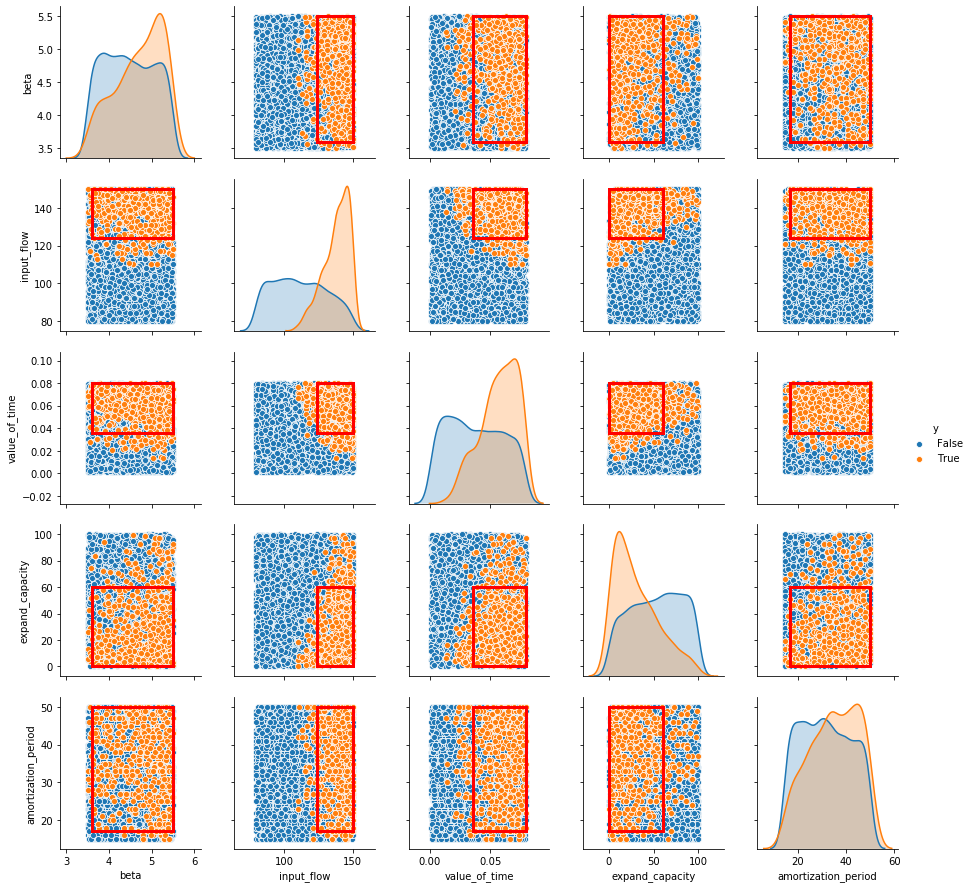

In [12]:
box1.show_pairs_scatter();

In [13]:
box1.to_emat_box()

Box: prim box 50
   coverage: 0.63410
   density:  0.60291
   mass:     0.10980
   ●                 beta >= 3.596707222226851
   ●           input_flow >= 124
   ●        value_of_time >= 0.035868264493137895
   ●      expand_capacity <= 60.32420632136244
   ●  amortization_period >= 17

## Non-Rectangular Boxes

Regardless of any analyst intervention in box selection
using the `select` method, initial box identified using PRIM
will always be a rectangle (or, more generally, a hyper-rectangle).
Every restricted dimension is specified independently, not conditional
on any other dimension.  

A second box can be overlaid after the first to expand the solution
to include a non-rectangular area.  The second tier box itself is
still another rectangle, but it can be defined using different boundaries,
possibly on different dimensions, to give in aggregate a non-convex shape.
Creating such a second box is done by calling the `find_box` method again,
after the particulars of the first box are finalized.

In [14]:
box2 = discovery.find_box()

In [15]:
box2

<PrimBox peel 44 of 44>
   coverage: 0.16092
   density:  0.32558
   mean: 0.32558
   mass: 0.05160
   restricted dims: 5
                             min        max
     expand_capacity  0.00481239    97.2013
     input_flow              110        150
     debt_type           {Paygo}    {Paygo}
     value_of_time     0.0287804  0.0799966
     alpha              0.137424   0.199972

The cases considered for the second box are *only* those cases
not within the first box.  Because our first box had a relatively
high coverage and high density, we have already captured most of
the cases of interest and not too many other cases, so the 
second box has a much diminished trade-off curve.  The maximum
value of the coverage for this second box is one minus the 
selected final coverage of the first box.

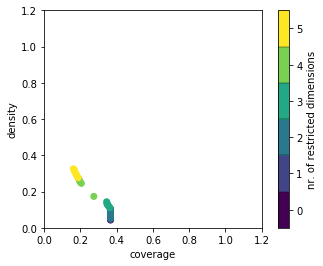

In [16]:
box2.show_tradeoff();

We can also make a similar scatter plot for this second box.
Because this is the second box, the method will only plot the 
points that remain (i.e. the ones not included in the first
box).  This results in a "blotchy" appearance for may of the 
graphs in this figure, as most of the "of interest" cases were
captured previously.

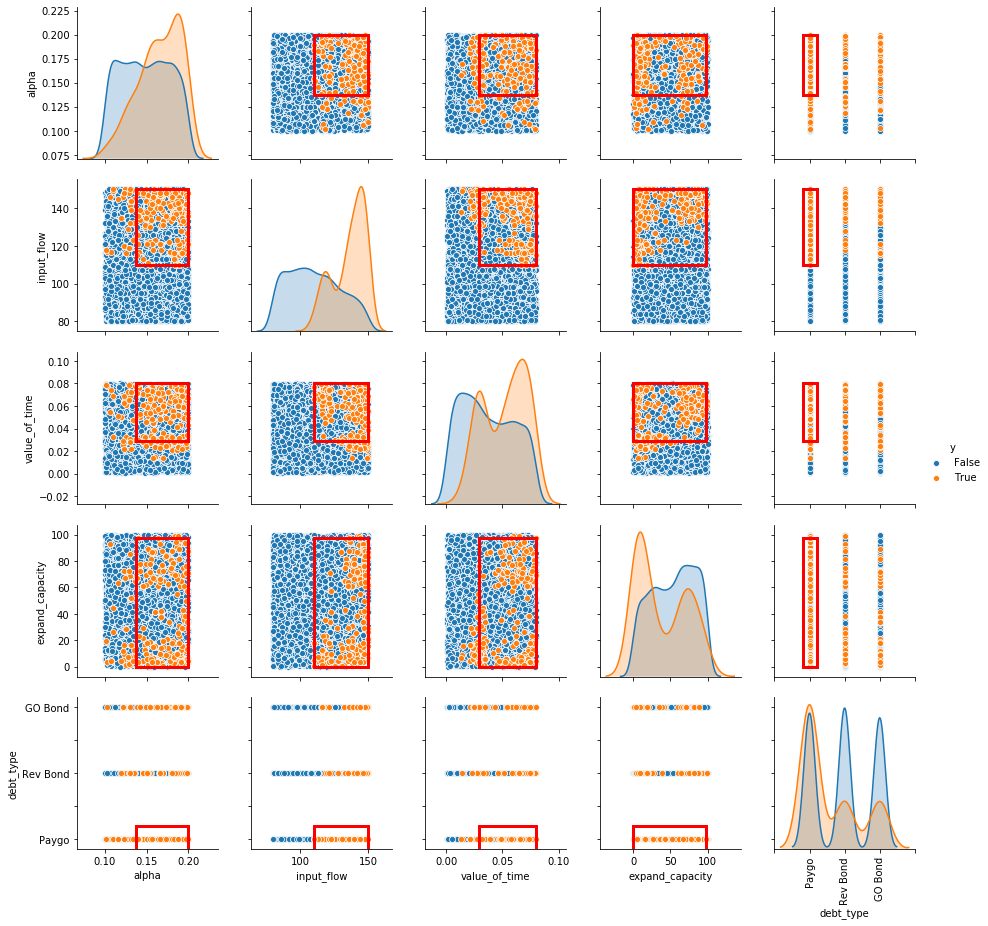

In [17]:
box2.show_pairs_scatter();